# 準備

## Import 

In [1]:
# !pip install albumentations

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import torchvision
import numpy as np
import gc  
from albumentations import (
    Compose, Normalize, Resize,
    RandomResizedCrop, HorizontalFlip,
    RandomBrightnessContrast, ShiftScaleRotate
)
from albumentations.pytorch import ToTensorV2
import cv2
from datetime import datetime
import pytz
from tqdm import tqdm
import timm

In [3]:
class Config:
    patience=10
    num_epochs=80
    mixup_epochs=5
    batch_size=24
    
config = Config()

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Use a chosen seed
set_seed(42)

In [5]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# Get current date and time in JST
jst = pytz.timezone('Asia/Tokyo')
current_datetime = datetime.now(jst)
# Get current date and time
formatted_datetime = current_datetime.strftime('%Y%m%d%H%M%S')

print(formatted_datetime)

20230828141332


In [7]:
formatted_datetime=20230827183401

## Path

## def

In [8]:
def view_img(dir_name, file_name):
    
    info_table = pd.read_csv(f'../data/{dir_name}.csv', header=None, names=['name', 'label'])
    target_label = info_table[info_table['name']==f'{file_name}']['label']
    
    # # Display the image
    img = Image.open(f'../data/{dir_name}/'+file_name)
    # img = Image.open('../data/train_1/'+f'train_1811.png')
    
    plt.title(file_name)
    plt.imshow(img)
    plt.show()

    print("Label:", target_label.values[0])  # values[0] is used to get the first value if multiple rows match the condition
    print("Size of the image:", img.size)


# EDA

In [9]:
# df = pd.read_csv('../data/train_1.csv', header=None, names=['name', 'label'])
# df.head(3)

In [10]:
# random_idx = random.choice(range(len(df)))
# file_name = f'train_{random_idx}.png'
# dir_name = 'train_1'

# view_img(dir_name, file_name)

In [11]:
# # Directory to search
# directory = "../data/train_1/"

# # Maximum file size in bytes (40K in this case)
# max_size = 40 * 1024

# # Get list of files in the directory and subdirectories
# file_list = []

# for directory in ["../data/train_1/","../data/train_2/","../data/train_3/","../data/train_4/"]:
#     for foldername, subfolders, filenames in os.walk(directory):
#         for filename in filenames:
#             full_path = os.path.join(foldername, filename)
#             if os.path.getsize(full_path) <= max_size:
#                 file_list.append(full_path)

In [12]:
# file_list

In [13]:
# file_name = f'train_1474.png'
# dir_name = 'train_3'

# view_img(dir_name, file_name)

In [14]:
# # Get image paths for label 0 and 1
# image_paths_0 = df[df['label'] == 0]['name'].values
# image_paths_1 = df[df['label'] == 1]['name'].values

# # Function to display images
# def display_images(image_paths, title):
#     plt.figure(figsize=(10,10))
#     for i in range(9):  # display 9 images
#         plt.subplot(3,3,i+1)
#         img = Image.open(image_paths[i])
#         plt.imshow(img)
#         plt.title(title)
#         plt.axis('off')
#     plt.show()

# # Display images for label 0 and 1
# display_images('../data/train_1/'+ image_paths_0, 'label_0')
# display_images('../data/train_1/'+ image_paths_1, 'label_1')

# ## 画像が欠損しているデータもあり

In [15]:
# df.groupby('label')['name'].count()

# ベースモデル

## 学習フェーズ

### 関数

In [16]:
def get_transforms():
    transforms_dict = {
        'train': Compose([
            RandomResizedCrop(512, 512),
            HorizontalFlip(),
            RandomBrightnessContrast(),
            ShiftScaleRotate(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        'valid': Compose([
            Resize(512, 512),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
    }
    return transforms_dict


def load_datasets(df, root_dir, transforms_dict):
    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
    datasets = {
        'train': CustomImageDataset(train_df, root_dir, transform=transforms_dict['train']),
        'valid': CustomImageDataset(valid_df, root_dir, transform=transforms_dict['valid'])
    }
    return datasets


def get_dataloaders(datasets, batch_size):
    dataloaders = {
        'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(datasets['valid'], batch_size=batch_size, shuffle=False)
    }
    return dataloaders

    
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        label = self.df.iloc[idx, 1]
        if self.transform:
            transformed = self.transform(image=image)  # Apply the transformations
            image = transformed["image"]
        return image, label
    
def train_model(dataloaders, model, criterion, optimizer, num_epochs, file_name):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_predictions += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            


    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
    
    
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
          

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
    # val_loss_minの値を取得
    def get_value(self):
        return self.val_loss_min
        
def train_model_mixup_el_stop(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, path=f'../models/{formatted_datetime}_{file_name}.pth',verbose=True)
    stop_training = False  # 早期停止フラグ
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid':
                early_stopping(-epoch_acc, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    stop_training = True
                    break

        if stop_training:
            break
 
    print('Finished Training') 
    
    return early_stopping.get_value()

### 実行

In [19]:
eval_dict=dict()

for ds in ['train_1','train_2','train_3','train_4']:
# for ds in ['train_4']:

    print(f'=== {ds}  学習中 ===')
    
    # Load labels from csv
    df = pd.read_csv(f'../data/{ds}.csv', header=None, names=['name', 'label'])
    
    # 40kB以下の空白画像をdfから削除
    file_list = []
    for foldername, subfolders, filenames in os.walk(os.path.join("../data/",ds)):
        for filename in filenames:
            full_path = os.path.join(foldername, filename)
            max_size = 40 * 1024
            if os.path.getsize(full_path) <= max_size:
                file_list.append(filename)
    df = df[~df['name'].isin(file_list)]
    
    # Get transforms
    transforms_dict = get_transforms()

    # Load datasets
    datasets = load_datasets(df, f'../data/{ds}/', transforms_dict)

    # Create dataloaders
    dataloaders = get_dataloaders(datasets, batch_size=config.batch_size)

    # Define model
#     model = torchvision.models.resnet50()

#     model = torchvision.models.resnet50(pretrained=True)
#     model.fc = nn.Linear(model.fc.in_features, 2) 
    model = timm.create_model('efficientnet_b0', pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, 2) 

    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train the model
#     train_model(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds)
#     train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds, mixup_epochs=10)
    eval_dict[ds]= train_model_mixup_el_stop(
        dataloaders,
        model, 
        criterion,
        optimizer,
        num_epochs=config.num_epochs,
        file_name=ds, 
        mixup_epochs=config.mixup_epochs,
        patience=config.patience
    )

del df
del dataloaders
gc.collect()

=== train_1  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 165/165 [02:24<00:00,  1.14it/s]


train Loss: 0.6093 Acc: 0.6656


100%|███████████████████████████████████████████| 42/42 [00:19<00:00,  2.17it/s]


valid Loss: 0.8449 Acc: 0.7699
Validation loss decreased (inf --> -0.769929).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.5010 Acc: 0.7618


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 1.3555 Acc: 0.8406
Validation loss decreased (-0.769929 --> -0.840565).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.4592 Acc: 0.7937


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.4699 Acc: 0.8658
Validation loss decreased (-0.840565 --> -0.865792).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.4263 Acc: 0.8156


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.4291 Acc: 0.8930
Validation loss decreased (-0.865792 --> -0.893037).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.4061 Acc: 0.8245


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.3059 Acc: 0.8880
EarlyStopping counter: 1 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.2057 Acc: 0.9263


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 1.1024 Acc: 0.9142
Validation loss decreased (-0.893037 --> -0.914228).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.1695 Acc: 0.9354


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1570 Acc: 0.9384
Validation loss decreased (-0.914228 --> -0.938446).  Saving model ...
Epoch 8/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.1542 Acc: 0.9402


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1278 Acc: 0.9455
Validation loss decreased (-0.938446 --> -0.945510).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.1350 Acc: 0.9460


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1345 Acc: 0.9526
Validation loss decreased (-0.945510 --> -0.952573).  Saving model ...
Epoch 10/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.1109 Acc: 0.9588


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1648 Acc: 0.9455
EarlyStopping counter: 1 out of 10
Epoch 11/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.1138 Acc: 0.9515


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1830 Acc: 0.9415
EarlyStopping counter: 2 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.1028 Acc: 0.9631


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.1277 Acc: 0.9465
EarlyStopping counter: 3 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0954 Acc: 0.9626


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1019 Acc: 0.9586
Validation loss decreased (-0.952573 --> -0.958628).  Saving model ...
Epoch 14/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.0885 Acc: 0.9692


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1323 Acc: 0.9455
EarlyStopping counter: 1 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0801 Acc: 0.9697


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1647 Acc: 0.9425
EarlyStopping counter: 2 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.0910 Acc: 0.9672


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1028 Acc: 0.9556
EarlyStopping counter: 3 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.0752 Acc: 0.9727


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0975 Acc: 0.9606
Validation loss decreased (-0.958628 --> -0.960646).  Saving model ...
Epoch 18/80
----------


100%|█████████████████████████████████████████| 165/165 [02:17<00:00,  1.20it/s]


train Loss: 0.0714 Acc: 0.9735


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0771 Acc: 0.9738
Validation loss decreased (-0.960646 --> -0.973764).  Saving model ...
Epoch 19/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0660 Acc: 0.9765


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0896 Acc: 0.9687
EarlyStopping counter: 1 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.0631 Acc: 0.9753


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1111 Acc: 0.9617
EarlyStopping counter: 2 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.0589 Acc: 0.9778


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0872 Acc: 0.9677
EarlyStopping counter: 3 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0458 Acc: 0.9859


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1113 Acc: 0.9617
EarlyStopping counter: 4 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0500 Acc: 0.9808


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1110 Acc: 0.9586
EarlyStopping counter: 5 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0539 Acc: 0.9788


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1036 Acc: 0.9556
EarlyStopping counter: 6 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0624 Acc: 0.9770


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0783 Acc: 0.9697
EarlyStopping counter: 7 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0470 Acc: 0.9828


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.26it/s]


valid Loss: 0.1099 Acc: 0.9627
EarlyStopping counter: 8 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0502 Acc: 0.9831


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0955 Acc: 0.9677
EarlyStopping counter: 9 out of 10
Epoch 28/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0454 Acc: 0.9826


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0836 Acc: 0.9647
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
=== train_2  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 165/165 [02:22<00:00,  1.16it/s]


train Loss: 0.6244 Acc: 0.6521


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.5040 Acc: 0.7962
Validation loss decreased (inf --> -0.796165).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 165/165 [02:22<00:00,  1.16it/s]


train Loss: 0.5157 Acc: 0.7530


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.3806 Acc: 0.8456
Validation loss decreased (-0.796165 --> -0.845610).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 165/165 [02:22<00:00,  1.16it/s]


train Loss: 0.4537 Acc: 0.7954


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.4034 Acc: 0.8668
Validation loss decreased (-0.845610 --> -0.866801).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.4318 Acc: 0.8077


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.3049 Acc: 0.8910
Validation loss decreased (-0.866801 --> -0.891019).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.4128 Acc: 0.8243


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.5488 Acc: 0.9122
Validation loss decreased (-0.891019 --> -0.912210).  Saving model ...
Epoch 6/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.2278 Acc: 0.9167


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.2826 Acc: 0.9213
Validation loss decreased (-0.912210 --> -0.921292).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 165/165 [02:17<00:00,  1.20it/s]


train Loss: 0.1869 Acc: 0.9263


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.2235 Acc: 0.8940
EarlyStopping counter: 1 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.1603 Acc: 0.9341


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1364 Acc: 0.9495
Validation loss decreased (-0.921292 --> -0.949546).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.1427 Acc: 0.9462


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1509 Acc: 0.9405
EarlyStopping counter: 1 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.1299 Acc: 0.9538


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1377 Acc: 0.9374
EarlyStopping counter: 2 out of 10
Epoch 11/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.1165 Acc: 0.9545


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1246 Acc: 0.9465
EarlyStopping counter: 3 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.1012 Acc: 0.9629


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1331 Acc: 0.9435
EarlyStopping counter: 4 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0886 Acc: 0.9662


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1127 Acc: 0.9526
Validation loss decreased (-0.949546 --> -0.952573).  Saving model ...
Epoch 14/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0945 Acc: 0.9646


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1310 Acc: 0.9506
EarlyStopping counter: 1 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 165/165 [02:22<00:00,  1.16it/s]


train Loss: 0.0724 Acc: 0.9747


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.26it/s]


valid Loss: 0.1062 Acc: 0.9536
Validation loss decreased (-0.952573 --> -0.953582).  Saving model ...
Epoch 16/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0735 Acc: 0.9694


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1200 Acc: 0.9506
EarlyStopping counter: 1 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0737 Acc: 0.9732


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1227 Acc: 0.9395
EarlyStopping counter: 2 out of 10
Epoch 18/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.0731 Acc: 0.9710


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1076 Acc: 0.9556
Validation loss decreased (-0.953582 --> -0.955600).  Saving model ...
Epoch 19/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0643 Acc: 0.9760


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.1244 Acc: 0.9495
EarlyStopping counter: 1 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0658 Acc: 0.9773


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1068 Acc: 0.9596
Validation loss decreased (-0.955600 --> -0.959637).  Saving model ...
Epoch 21/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0428 Acc: 0.9848


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1051 Acc: 0.9576
EarlyStopping counter: 1 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0571 Acc: 0.9785


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0992 Acc: 0.9627
Validation loss decreased (-0.959637 --> -0.962664).  Saving model ...
Epoch 23/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0621 Acc: 0.9775


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0896 Acc: 0.9667
Validation loss decreased (-0.962664 --> -0.966700).  Saving model ...
Epoch 24/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.20it/s]


train Loss: 0.0508 Acc: 0.9821


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0837 Acc: 0.9637
EarlyStopping counter: 1 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.19it/s]


train Loss: 0.0560 Acc: 0.9793


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0853 Acc: 0.9657
EarlyStopping counter: 2 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.0490 Acc: 0.9826


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0846 Acc: 0.9647
EarlyStopping counter: 3 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0501 Acc: 0.9795


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0975 Acc: 0.9627
EarlyStopping counter: 4 out of 10
Epoch 28/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.0398 Acc: 0.9854


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1188 Acc: 0.9526
EarlyStopping counter: 5 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0521 Acc: 0.9803


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0916 Acc: 0.9637
EarlyStopping counter: 6 out of 10
Epoch 30/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0392 Acc: 0.9866


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0891 Acc: 0.9596
EarlyStopping counter: 7 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0380 Acc: 0.9866


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0756 Acc: 0.9717
Validation loss decreased (-0.966700 --> -0.971746).  Saving model ...
Epoch 32/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0331 Acc: 0.9884


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0860 Acc: 0.9677
EarlyStopping counter: 1 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.18it/s]


train Loss: 0.0370 Acc: 0.9874


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0839 Acc: 0.9697
EarlyStopping counter: 2 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0324 Acc: 0.9884


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.0942 Acc: 0.9717
Validation loss decreased (-0.971746 --> -0.971746).  Saving model ...
Epoch 35/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.0436 Acc: 0.9876


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0760 Acc: 0.9748
Validation loss decreased (-0.971746 --> -0.974773).  Saving model ...
Epoch 36/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0414 Acc: 0.9823


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0722 Acc: 0.9707
EarlyStopping counter: 1 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0300 Acc: 0.9886


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.0668 Acc: 0.9768
Validation loss decreased (-0.974773 --> -0.976791).  Saving model ...
Epoch 38/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0357 Acc: 0.9871


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0691 Acc: 0.9738
EarlyStopping counter: 1 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0362 Acc: 0.9874


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0570 Acc: 0.9808
Validation loss decreased (-0.976791 --> -0.980827).  Saving model ...
Epoch 40/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0303 Acc: 0.9894


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0621 Acc: 0.9818
Validation loss decreased (-0.980827 --> -0.981837).  Saving model ...
Epoch 41/80
----------


100%|█████████████████████████████████████████| 165/165 [02:20<00:00,  1.17it/s]


train Loss: 0.0430 Acc: 0.9841


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0522 Acc: 0.9788
EarlyStopping counter: 1 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0363 Acc: 0.9871


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0575 Acc: 0.9808
EarlyStopping counter: 2 out of 10
Epoch 43/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0325 Acc: 0.9889


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0544 Acc: 0.9788
EarlyStopping counter: 3 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0247 Acc: 0.9924


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0568 Acc: 0.9778
EarlyStopping counter: 4 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0225 Acc: 0.9929


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0557 Acc: 0.9798
EarlyStopping counter: 5 out of 10
Epoch 46/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0305 Acc: 0.9907


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0562 Acc: 0.9808
EarlyStopping counter: 6 out of 10
Epoch 47/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0290 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1001 Acc: 0.9667
EarlyStopping counter: 7 out of 10
Epoch 48/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0266 Acc: 0.9904


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0672 Acc: 0.9728
EarlyStopping counter: 8 out of 10
Epoch 49/80
----------


100%|█████████████████████████████████████████| 165/165 [02:22<00:00,  1.16it/s]


train Loss: 0.0282 Acc: 0.9902


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0513 Acc: 0.9859
Validation loss decreased (-0.981837 --> -0.985873).  Saving model ...
Epoch 50/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0286 Acc: 0.9909


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0659 Acc: 0.9778
EarlyStopping counter: 1 out of 10
Epoch 51/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0244 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0518 Acc: 0.9818
EarlyStopping counter: 2 out of 10
Epoch 52/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0233 Acc: 0.9919


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0605 Acc: 0.9828
EarlyStopping counter: 3 out of 10
Epoch 53/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0235 Acc: 0.9912


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0523 Acc: 0.9798
EarlyStopping counter: 4 out of 10
Epoch 54/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0215 Acc: 0.9934


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0493 Acc: 0.9859
Validation loss decreased (-0.985873 --> -0.985873).  Saving model ...
Epoch 55/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0268 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0416 Acc: 0.9889
Validation loss decreased (-0.985873 --> -0.988900).  Saving model ...
Epoch 56/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0254 Acc: 0.9894


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0638 Acc: 0.9818
EarlyStopping counter: 1 out of 10
Epoch 57/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0244 Acc: 0.9922


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0656 Acc: 0.9788
EarlyStopping counter: 2 out of 10
Epoch 58/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.17it/s]


train Loss: 0.0189 Acc: 0.9942


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0560 Acc: 0.9778
EarlyStopping counter: 3 out of 10
Epoch 59/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0213 Acc: 0.9924


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0549 Acc: 0.9788
EarlyStopping counter: 4 out of 10
Epoch 60/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0270 Acc: 0.9909


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0631 Acc: 0.9788
EarlyStopping counter: 5 out of 10
Epoch 61/80
----------


100%|█████████████████████████████████████████| 165/165 [02:21<00:00,  1.16it/s]


train Loss: 0.0210 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0468 Acc: 0.9818
EarlyStopping counter: 6 out of 10
Epoch 62/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.18it/s]


train Loss: 0.0178 Acc: 0.9944


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0626 Acc: 0.9849
EarlyStopping counter: 7 out of 10
Epoch 63/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0153 Acc: 0.9960


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0820 Acc: 0.9738
EarlyStopping counter: 8 out of 10
Epoch 64/80
----------


100%|█████████████████████████████████████████| 165/165 [02:18<00:00,  1.19it/s]


train Loss: 0.0176 Acc: 0.9939


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0543 Acc: 0.9818
EarlyStopping counter: 9 out of 10
Epoch 65/80
----------


100%|█████████████████████████████████████████| 165/165 [02:19<00:00,  1.19it/s]


train Loss: 0.0143 Acc: 0.9949


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0573 Acc: 0.9758
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
=== train_3  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.6302 Acc: 0.6375


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.4913 Acc: 0.7966
Validation loss decreased (inf --> -0.796576).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.5340 Acc: 0.7432


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.3831 Acc: 0.8479
Validation loss decreased (-0.796576 --> -0.847936).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.4702 Acc: 0.7846


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.3356 Acc: 0.8882
Validation loss decreased (-0.847936 --> -0.888218).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.4444 Acc: 0.8001


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 1.1944 Acc: 0.8902
Validation loss decreased (-0.888218 --> -0.890232).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.4067 Acc: 0.8321


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.2551 Acc: 0.9124
Validation loss decreased (-0.890232 --> -0.912387).  Saving model ...
Epoch 6/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.2257 Acc: 0.9147


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 2.8012 Acc: 0.8993
EarlyStopping counter: 1 out of 10
Epoch 7/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.16it/s]


train Loss: 0.1859 Acc: 0.9252


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1920 Acc: 0.9396
Validation loss decreased (-0.912387 --> -0.939577).  Saving model ...
Epoch 8/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.16it/s]


train Loss: 0.1589 Acc: 0.9391


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1449 Acc: 0.9486
Validation loss decreased (-0.939577 --> -0.948640).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.16it/s]


train Loss: 0.1262 Acc: 0.9524


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1354 Acc: 0.9466
EarlyStopping counter: 1 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.1136 Acc: 0.9539


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1437 Acc: 0.9507
Validation loss decreased (-0.948640 --> -0.950655).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.1173 Acc: 0.9532


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.2798 Acc: 0.9557
Validation loss decreased (-0.950655 --> -0.955690).  Saving model ...
Epoch 12/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.1131 Acc: 0.9585


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1441 Acc: 0.9446
EarlyStopping counter: 1 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.1025 Acc: 0.9607


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.27it/s]


valid Loss: 0.1076 Acc: 0.9557
Validation loss decreased (-0.955690 --> -0.955690).  Saving model ...
Epoch 14/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.0938 Acc: 0.9637


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1276 Acc: 0.9486
EarlyStopping counter: 1 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.0832 Acc: 0.9675


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0989 Acc: 0.9627
Validation loss decreased (-0.955690 --> -0.962739).  Saving model ...
Epoch 16/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.0881 Acc: 0.9663


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.5995 Acc: 0.9507
EarlyStopping counter: 1 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0694 Acc: 0.9728


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0837 Acc: 0.9648
Validation loss decreased (-0.962739 --> -0.964753).  Saving model ...
Epoch 18/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0686 Acc: 0.9756


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1119 Acc: 0.9557
EarlyStopping counter: 1 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0691 Acc: 0.9761


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1007 Acc: 0.9648
Validation loss decreased (-0.964753 --> -0.964753).  Saving model ...
Epoch 20/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0609 Acc: 0.9768


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.0796 Acc: 0.9678
Validation loss decreased (-0.964753 --> -0.967774).  Saving model ...
Epoch 21/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.0627 Acc: 0.9781


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0676 Acc: 0.9768
Validation loss decreased (-0.967774 --> -0.976838).  Saving model ...
Epoch 22/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0602 Acc: 0.9801


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0834 Acc: 0.9688
EarlyStopping counter: 1 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.0574 Acc: 0.9794


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0593 Acc: 0.9728
EarlyStopping counter: 2 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0549 Acc: 0.9796


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0627 Acc: 0.9758
EarlyStopping counter: 3 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0404 Acc: 0.9854


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0440 Acc: 0.9839
Validation loss decreased (-0.976838 --> -0.983887).  Saving model ...
Epoch 26/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0482 Acc: 0.9839


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0641 Acc: 0.9778
EarlyStopping counter: 1 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0433 Acc: 0.9872


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0436 Acc: 0.9869
Validation loss decreased (-0.983887 --> -0.986908).  Saving model ...
Epoch 28/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0450 Acc: 0.9826


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0497 Acc: 0.9799
EarlyStopping counter: 1 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 166/166 [02:22<00:00,  1.17it/s]


train Loss: 0.0413 Acc: 0.9851


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0523 Acc: 0.9758
EarlyStopping counter: 2 out of 10
Epoch 30/80
----------


 61%|█████████████████████████▏               | 102/166 [01:28<00:55,  1.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.0307 Acc: 0.9892


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0680 Acc: 0.9698
EarlyStopping counter: 3 out of 10
Epoch 38/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.0413 Acc: 0.9862


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0410 Acc: 0.9819
EarlyStopping counter: 4 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0271 Acc: 0.9912


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0442 Acc: 0.9799
EarlyStopping counter: 5 out of 10
Epoch 40/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0380 Acc: 0.9849


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0345 Acc: 0.9849
EarlyStopping counter: 6 out of 10
Epoch 41/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.0282 Acc: 0.9894


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0396 Acc: 0.9809
EarlyStopping counter: 7 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.0273 Acc: 0.9894


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0330 Acc: 0.9879
Validation loss decreased (-0.987915 --> -0.987915).  Saving model ...
Epoch 43/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0384 Acc: 0.9862


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0257 Acc: 0.9909
Validation loss decreased (-0.987915 --> -0.990937).  Saving model ...
Epoch 45/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0232 Acc: 0.9909


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0402 Acc: 0.9849
EarlyStopping counter: 1 out of 10
Epoch 46/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0255 Acc: 0.9922


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0410 Acc: 0.9819
EarlyStopping counter: 2 out of 10
Epoch 47/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0277 Acc: 0.9902


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0477 Acc: 0.9829
EarlyStopping counter: 3 out of 10
Epoch 48/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0194 Acc: 0.9942


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0412 Acc: 0.9819
EarlyStopping counter: 4 out of 10
Epoch 49/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0256 Acc: 0.9917


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0359 Acc: 0.9869
EarlyStopping counter: 5 out of 10
Epoch 50/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0209 Acc: 0.9935


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0421 Acc: 0.9829
EarlyStopping counter: 6 out of 10
Epoch 51/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0159 Acc: 0.9957


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0343 Acc: 0.9869
EarlyStopping counter: 7 out of 10
Epoch 52/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.19it/s]


train Loss: 0.0222 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0500 Acc: 0.9778
EarlyStopping counter: 8 out of 10
Epoch 53/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0302 Acc: 0.9892


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0379 Acc: 0.9859
EarlyStopping counter: 9 out of 10
Epoch 54/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0189 Acc: 0.9930


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0388 Acc: 0.9839
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
=== train_4  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.19it/s]


train Loss: 0.6091 Acc: 0.6700


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.5592 Acc: 0.7881
Validation loss decreased (inf --> -0.788093).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.5082 Acc: 0.7547


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.7593 Acc: 0.8305
Validation loss decreased (-0.788093 --> -0.830474).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.4637 Acc: 0.7932


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.3626 Acc: 0.8638
Validation loss decreased (-0.830474 --> -0.863774).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.4230 Acc: 0.8199


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.3277 Acc: 0.8607
EarlyStopping counter: 1 out of 10
Epoch 5/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.4239 Acc: 0.8140


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.3331 Acc: 0.8476
EarlyStopping counter: 2 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.2324 Acc: 0.9129


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1699 Acc: 0.9546
Validation loss decreased (-0.863774 --> -0.954591).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.2016 Acc: 0.9200


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1773 Acc: 0.9354
EarlyStopping counter: 1 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.1692 Acc: 0.9331


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.1276 Acc: 0.9586
Validation loss decreased (-0.954591 --> -0.958628).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.1447 Acc: 0.9427


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.1170 Acc: 0.9576
EarlyStopping counter: 1 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.1311 Acc: 0.9485


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1491 Acc: 0.9415
EarlyStopping counter: 2 out of 10
Epoch 11/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.1246 Acc: 0.9543


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.1056 Acc: 0.9617
Validation loss decreased (-0.958628 --> -0.961655).  Saving model ...
Epoch 12/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.1045 Acc: 0.9591


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.1031 Acc: 0.9596
EarlyStopping counter: 1 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0940 Acc: 0.9664


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0855 Acc: 0.9657
Validation loss decreased (-0.961655 --> -0.965691).  Saving model ...
Epoch 14/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0937 Acc: 0.9616


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1219 Acc: 0.9516
EarlyStopping counter: 1 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.1125 Acc: 0.9563


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0476 Acc: 0.9839
Validation loss decreased (-0.965691 --> -0.983855).  Saving model ...
Epoch 16/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0826 Acc: 0.9672


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0961 Acc: 0.9657
EarlyStopping counter: 1 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0673 Acc: 0.9730


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.1008 Acc: 0.9617
EarlyStopping counter: 2 out of 10
Epoch 18/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0961 Acc: 0.9644


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.0697 Acc: 0.9778
EarlyStopping counter: 3 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0709 Acc: 0.9755


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0672 Acc: 0.9738
EarlyStopping counter: 4 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0645 Acc: 0.9758


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0409 Acc: 0.9828
EarlyStopping counter: 5 out of 10
Epoch 21/80
----------


 36%|██████████████▉                           | 59/166 [00:50<01:31,  1.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0546 Acc: 0.9803


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0383 Acc: 0.9859
Validation loss decreased (-0.984864 --> -0.985873).  Saving model ...
Epoch 28/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0565 Acc: 0.9798


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0526 Acc: 0.9778
EarlyStopping counter: 1 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0634 Acc: 0.9760


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0491 Acc: 0.9828
EarlyStopping counter: 2 out of 10
Epoch 30/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0446 Acc: 0.9833


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.0478 Acc: 0.9778
EarlyStopping counter: 3 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.0400 Acc: 0.9866


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0315 Acc: 0.9899
Validation loss decreased (-0.985873 --> -0.989909).  Saving model ...
Epoch 32/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0367 Acc: 0.9869


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0426 Acc: 0.9828
EarlyStopping counter: 1 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0389 Acc: 0.9846


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0568 Acc: 0.9828
EarlyStopping counter: 2 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0556 Acc: 0.9798


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0406 Acc: 0.9849
EarlyStopping counter: 3 out of 10
Epoch 35/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0379 Acc: 0.9859


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0371 Acc: 0.9899
Validation loss decreased (-0.989909 --> -0.989909).  Saving model ...
Epoch 36/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0441 Acc: 0.9836


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0423 Acc: 0.9828
EarlyStopping counter: 1 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0609 Acc: 0.9780


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0482 Acc: 0.9778
EarlyStopping counter: 2 out of 10
Epoch 38/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0336 Acc: 0.9861


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.26it/s]


valid Loss: 0.0383 Acc: 0.9818
EarlyStopping counter: 3 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.17it/s]


train Loss: 0.0325 Acc: 0.9876


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0427 Acc: 0.9808
EarlyStopping counter: 4 out of 10
Epoch 40/80
----------


100%|█████████████████████████████████████████| 166/166 [02:19<00:00,  1.19it/s]


train Loss: 0.0316 Acc: 0.9899


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.30it/s]


valid Loss: 0.0403 Acc: 0.9839
EarlyStopping counter: 5 out of 10
Epoch 41/80
----------


100%|█████████████████████████████████████████| 166/166 [02:18<00:00,  1.20it/s]


train Loss: 0.0324 Acc: 0.9904


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.31it/s]


valid Loss: 0.0435 Acc: 0.9828
EarlyStopping counter: 6 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0276 Acc: 0.9924


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0443 Acc: 0.9859
EarlyStopping counter: 7 out of 10
Epoch 43/80
----------


100%|█████████████████████████████████████████| 166/166 [02:20<00:00,  1.18it/s]


train Loss: 0.0325 Acc: 0.9886


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0357 Acc: 0.9849
EarlyStopping counter: 8 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0197 Acc: 0.9929


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.29it/s]


valid Loss: 0.0379 Acc: 0.9859
EarlyStopping counter: 9 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 166/166 [02:21<00:00,  1.18it/s]


train Loss: 0.0313 Acc: 0.9894


100%|███████████████████████████████████████████| 42/42 [00:18<00:00,  2.28it/s]


valid Loss: 0.0456 Acc: 0.9828
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training


0

In [20]:
print(eval_dict)

{'train_1': -0.9737638748738647, 'train_2': -0.9889001009081736, 'train_3': -0.9909365558912386, 'train_4': -0.9899091826437941}


In [28]:
acc_ave = sum(eval_dict.values()) / len(eval_dict)
acc_ave = round(acc_ave, 4)
acc_ave = str(acc_ave)
acc_ave = acc_ave.replace('.', '_')

print(acc_ave)

-0_9859


## 予測フェーズ

### 関数

In [22]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, self.image_files[idx] 

### 実行

In [23]:
transforms_dict = get_transforms()

test_data = TestDataset(root_dir='../data/evaluation/', transform=transforms_dict['valid'])
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# モデルのパスをリストにします
model_paths = [
    f'../models/{formatted_datetime}_train_1.pth',
    f'../models/{formatted_datetime}_train_2.pth',
    f'../models/{formatted_datetime}_train_3.pth',
    f'../models/{formatted_datetime}_train_4.pth',
] 

# 空のリストを作成して各モデルの予測を格納します
all_predictions = []

for model_path in model_paths:
    print('■実行中:', model_path)
    
    # モデルのインスタンスを作成します
    model = timm.create_model('efficientnet_b0', pretrained=False)
#     model.fc = nn.Linear(model.fc.in_features, 2) 
    model.classifier = nn.Linear(model.classifier.in_features, 2) 

    # 状態辞書をロードします
    model.load_state_dict(torch.load(model_path))

    # モデルをGPUに移動します
    model = model.to(device)

    # モデルを評価モードに設定します
    model.eval()

    # このモデルの予測を格納するリストを作成します
    model_predictions = []

    # データローダーからバッチを取得して予測を行います
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, _ = data
            images = images.to(device)
            
            logits = model(images)
            probabilities = F.softmax(logits, dim=1)  # apply softmax to convert logits to probabilities
            model_predictions.extend(probabilities.tolist())  # convert PyTorch tensor to Python list

    # すべてのモデルの予測を格納するリストにこのモデルの予測を追加します
    all_predictions.append(model_predictions)

# 全モデルの予測を平均します
final_predictions = np.mean(all_predictions, axis=0)

■実行中: ../models/20230827183401_train_1.pth


100%|█████████████████████████████████████████| 469/469 [04:39<00:00,  1.68it/s]


■実行中: ../models/20230827183401_train_2.pth


100%|█████████████████████████████████████████| 469/469 [04:39<00:00,  1.68it/s]


■実行中: ../models/20230827183401_train_3.pth


100%|█████████████████████████████████████████| 469/469 [04:40<00:00,  1.67it/s]


■実行中: ../models/20230827183401_train_4.pth


100%|█████████████████████████████████████████| 469/469 [04:39<00:00,  1.68it/s]


In [24]:
# submit用に整形
# Create a DataFrame with the image names and the probabilities
df_submission = pd.DataFrame({
    'image_name': [f'test_{i}.png' for i in range(len(final_predictions))],
    'probability': [probs[1] for probs in final_predictions]
})

# Write the DataFrame to a csv file
# df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}_acc{acc_ave}.csv', index=False,header=False)
df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}.csv', index=False,header=False)

<Axes: >

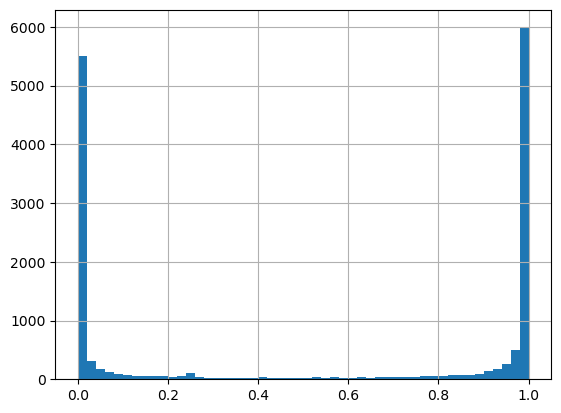

In [25]:
df_submission.probability.hist(bins=50)

In [26]:
df_submission.probability.min()

4.431108347736343e-08

In [27]:
df_submission.probability.max()

0.9999999403953552